In [1]:
import torch
import torchvision
import torch.autograd
import torch.nn
import torch.multiprocessing
import torch.utils

In [2]:
#pip install scikit-learn

In [3]:
torch.tensor([[1,2],[3,4]])

tensor([[1, 2],
        [3, 4]])

In [4]:
torch.tensor([[1,2],[3,4]], device="cuda:0")

tensor([[1, 2],
        [3, 4]], device='cuda:0')

In [5]:
temp = torch.tensor([[1,2],[3,4]])

In [6]:
temp.numpy()

array([[1, 2],
       [3, 4]], dtype=int64)

In [7]:
temp = torch.tensor([[1,2],[3,4]], device="cuda:0")

In [8]:
temp.to("cpu").numpy()

array([[1, 2],
       [3, 4]], dtype=int64)

In [9]:
temp = torch.FloatTensor([1,2,3,4,5,6,7])

In [10]:
temp[2:5]

tensor([3., 4., 5.])

In [11]:
v =torch.tensor([1,2,3])
w =torch.tensor([3,4,6])

In [12]:
v-w

tensor([-2, -2, -3])

In [13]:
temp = torch.tensor([[1,2],[3,4]])

In [14]:
temp.shape

torch.Size([2, 2])

In [15]:
temp.view(4,1)

tensor([[1],
        [2],
        [3],
        [4]])

In [16]:
temp.view(-1)

tensor([1, 2, 3, 4])

In [17]:
temp.view(-1,1)

tensor([[1],
        [2],
        [3],
        [4]])

# 2.4. Exercise

In [18]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
dataset = pd.read_csv('../chap02/data/car_evaluation.csv')
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<Axes: ylabel='count'>

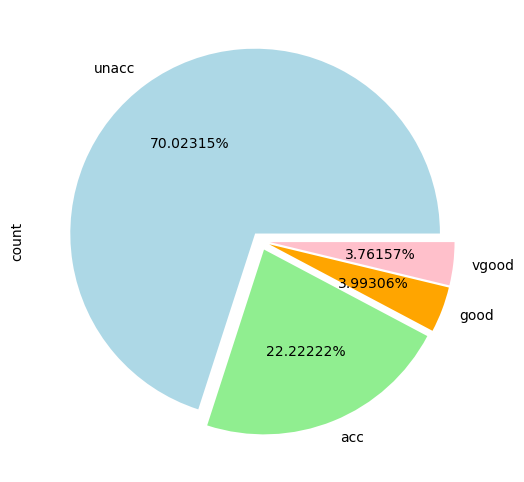

In [20]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0]=8
fig_size[1]=6
plt.rcParams['figure.figsize'] = fig_size
dataset.output.value_counts().plot(kind='pie',autopct='%0.05f%%',
                                  colors = ['lightblue', 'lightgreen', 'orange', 'pink'], explode = (0.05,0.05,0.05, 0.05))

In [21]:
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns :
    dataset[category] = dataset[category].astype('category')
    
price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety],1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [22]:
categorical_data = torch.tensor(categorical_data, dtype = torch.int64)
categorical_data

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        ...,
        [1, 1, 3, 2, 0, 1],
        [1, 1, 3, 2, 0, 2],
        [1, 1, 3, 2, 0, 0]])

In [23]:
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten()

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


In [24]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50,(col_size+1)//2)) for col_size in categorical_column_sizes]
categorical_embedding_sizes

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]

In [25]:
total_records = 1728
test_records = int(total_records*.2)

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

In [26]:
print(len(categorical_train_data))
print(len(categorical_test_data))
print(len(train_outputs))
print(len(test_outputs))

1383
345
1383
345


In [27]:
class Model(nn.Module):
    def __init__(self,embedding_size,output_size,layers,p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        
        all_layers =[]
        num_categorical_cols = sum((nf for ni,nf in embedding_size))
        input_size = num_categorical_cols
        
        for i in layers :
            all_layers.append(nn.Linear(input_size,i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i
            
        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)
        
    def forward(self, x_categorical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings,1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

In [28]:
model = Model(categorical_embedding_sizes, 4, [250,125,50], p=0.4)
model

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=250, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=250, out_features=125, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=125, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)

In [29]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [31]:
device

device(type='cuda')

In [32]:
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs):
    i+=1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)
    
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 1.53562224
epoch:  26 loss: 1.36761677
epoch:  51 loss: 1.30102813
epoch:  76 loss: 1.19843006
epoch: 101 loss: 1.06579542
epoch: 126 loss: 0.91962874
epoch: 151 loss: 0.80269641
epoch: 176 loss: 0.73203754
epoch: 201 loss: 0.67396432
epoch: 226 loss: 0.65058273
epoch: 251 loss: 0.62732804
epoch: 276 loss: 0.60132974
epoch: 301 loss: 0.59620082
epoch: 326 loss: 0.59072316
epoch: 351 loss: 0.59054345
epoch: 376 loss: 0.57667416
epoch: 401 loss: 0.57673502
epoch: 426 loss: 0.57334423
epoch: 451 loss: 0.56744623
epoch: 476 loss: 0.56370574
epoch: 500 loss: 0.5699689388


In [33]:
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data).to(device)
    loss = loss_function(y_val,test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.55308884


In [34]:
print(y_val[:5])

tensor([[ 3.2651,  0.9965, -4.2560, -3.9442],
        [ 1.9554,  0.9962, -3.4928, -3.3218],
        [ 1.9012,  1.1649, -2.2886, -2.1585],
        [ 2.7167,  1.8825, -2.6843, -2.7863],
        [ 2.0371,  1.0347, -3.1686, -2.9911]], device='cuda:0')


In [35]:
y_val = y_val.to('cpu')
test_outputs = test_outputs.to('cpu')

In [36]:
y_val = np.argmax(y_val,axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(test_outputs,y_val))
print(classification_report(test_outputs,y_val))
print(accuracy_score(test_outputs,y_val))

[[259   0]
 [ 85   1]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       259
           1       1.00      0.01      0.02        86

    accuracy                           0.75       345
   macro avg       0.88      0.51      0.44       345
weighted avg       0.81      0.75      0.65       345

0.7536231884057971
